# Simplified Chinese 1-grams

In [1]:
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from parse_util import is_cjk
from graph_util import *

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm

font_path = '/home/ycm/.fonts/SourceHanSansSC-Regular.otf'
prop = mfm.FontProperties(fname=font_path)

In [3]:
with open('CHAR_TO_IDS.pkl', 'rb') as f:
    char_to_ids = pkl.load(f)
char_to_ids['书'] = Char('书')
char_to_ids['已'] = Char('已')
char_to_ids['亊'] = Char('亊')
char_to_ids['枭'] = Char('枭')
char_to_ids['枭'] = Char('枭')
char_to_ids['袅'] = Char('袅')

In [4]:
N_YEARS_PER_BLOCK = 5
START_YEAR = 1950
time_periods = list(range(START_YEAR,
                          START_YEAR + 1 + N_YEARS_PER_BLOCK * min(i for i in range(125) if START_YEAR + i * N_YEARS_PER_BLOCK >= 2020),
                          N_YEARS_PER_BLOCK))

In [5]:
def make_row_for_term(term, pos, stats):
    rv = {'term': term, 'pos': pos}
    
    for begin_year in time_periods:
        rv[f'{begin_year}_n_occ'] = 0
        rv[f'{begin_year}_n_occ_norm'] = 0
    
    for stat in stats:
        year, n_occs, n_vols = stat.split(',')
        for begin_year in reversed(time_periods):
            if begin_year <= int(year):
                rv[f'{begin_year}_n_occ'] += int(n_occs)
                rv[f'{begin_year}_n_occ_norm'] += int(n_occs) / int(n_vols)
                break
    return rv

## Part 1: Only POS-tagged 1-grams

In [6]:
def is_cjk_and_has_POS(s):
    ss = s.split('_')
    return len(ss) == 2 and ss[0] and all(is_cjk(c) for c in ss[0]) and ss[1].isalpha()

POS_raw_counter = Counter()
uniq_chars = ''
df = []
with open('data/chi-sim-1gram-2020.tsv') as f:
    for i, line in enumerate(f):
        ln = line.strip().split()
        if is_cjk_and_has_POS(ln[0]):
            term, POS = ln[0].split('_')
            POS_raw_counter[POS] += 1
            uniq_chars += term
            df.append(make_row_for_term(term, POS, ln[1:]))
#             break

In [7]:
print(f'Unique characters: {len(set(uniq_chars))}')

Unique characters: 4778


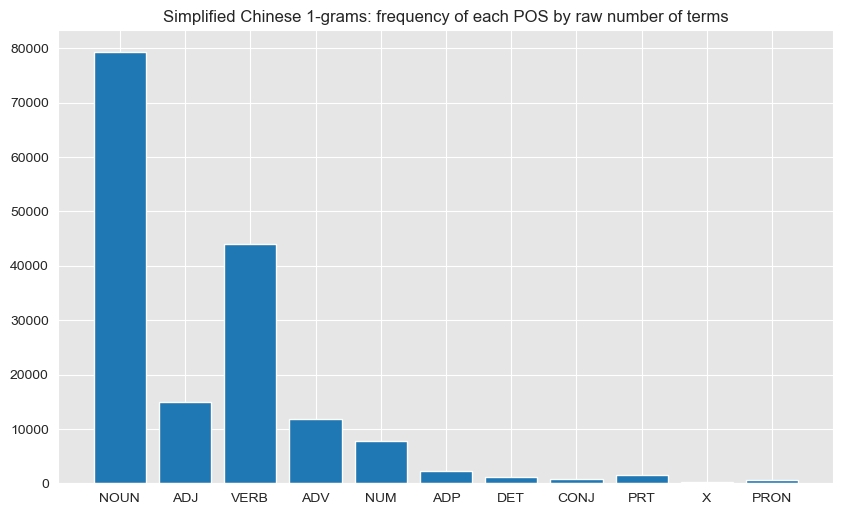

In [8]:
POSs = list(POS_raw_counter.keys())
POS_counts = [POS_raw_counter[p] for p in POSs]
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Simplified Chinese 1-grams: frequency of each POS by raw number of terms')
plt.bar(POSs, POS_counts)
plt.show()

In [31]:
df = pd.DataFrame(df)
df.to_pickle('df_full_5y.pkl')

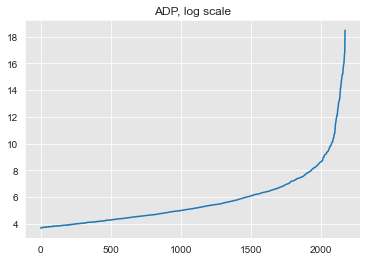

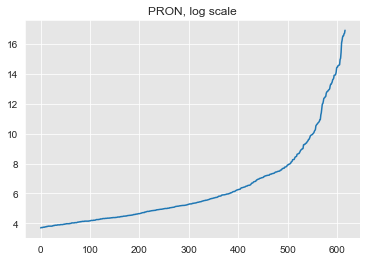

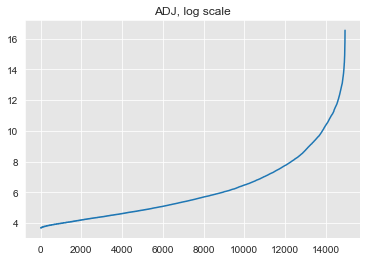

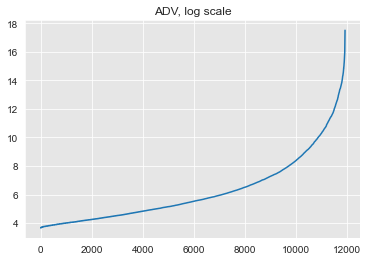

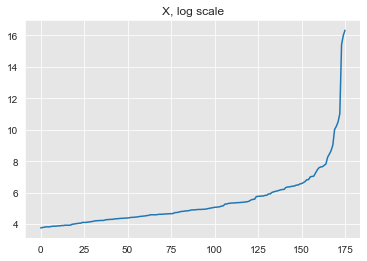

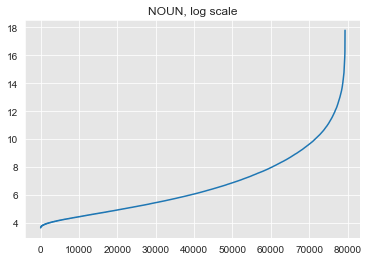

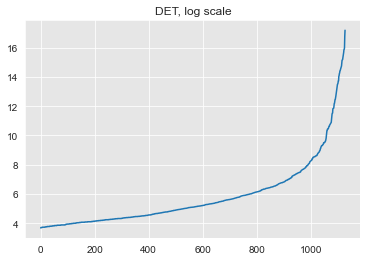

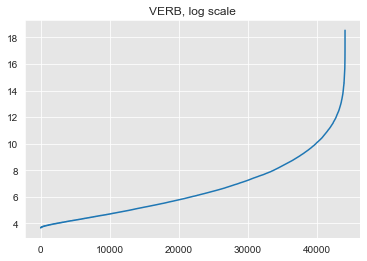

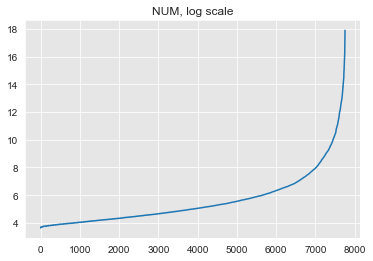

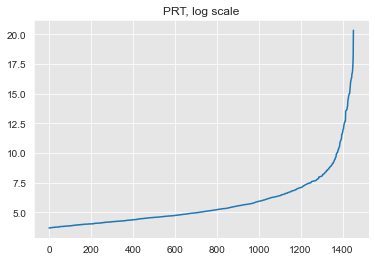

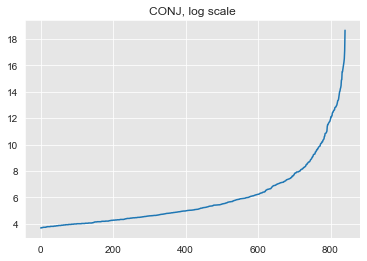

In [30]:
for pos in set(df.pos):
    df_pos = df[df.pos == pos]
    counts = [
        np.log(sum(r[f'{t}_n_occ'] for t in time_periods))
        for _, r in df_pos.iterrows()
    ]
    plt.title(pos + ', log scale')
    plt.plot(sorted(counts))
    plt.show()

In [29]:
N = 200
for pos in set(df.pos):
    df_pos = df[df.pos == pos]
    counts = [
        sum(r[f'{t}_n_occ'] for t in time_periods)
        for _, r in df_pos.iterrows()
    ]
    counts_above_N = [c for c in counts if c >= N]
    print(f'{pos}: {len(counts_above_N)} / {len(counts)} above {N} ({int(100 * len(counts_above_N) / len(counts))}%)')

ADP: 1003 / 2169 above 200 (46%)
PRON: 314 / 617 above 200 (50%)
ADJ: 8225 / 14942 above 200 (55%)
ADV: 6494 / 11911 above 200 (54%)
X: 68 / 176 above 200 (38%)
NOUN: 52042 / 79348 above 200 (65%)
DET: 508 / 1127 above 200 (45%)
VERB: 28365 / 44032 above 200 (64%)
NUM: 3233 / 7757 above 200 (41%)
PRT: 629 / 1453 above 200 (43%)
CONJ: 378 / 841 above 200 (44%)


In [140]:
def get_first_child(term):
    rv = ''
    for char in term:
        child = char_to_ids[char].child
        if child is None:
            return None
        rv += child.symbol
    return rv

first_child = [get_first_child(term) for term in df.term]
df['first_children'] = first_child

## Distribution of word lengths, by POS

<AxesSubplot:xlabel='pos'>

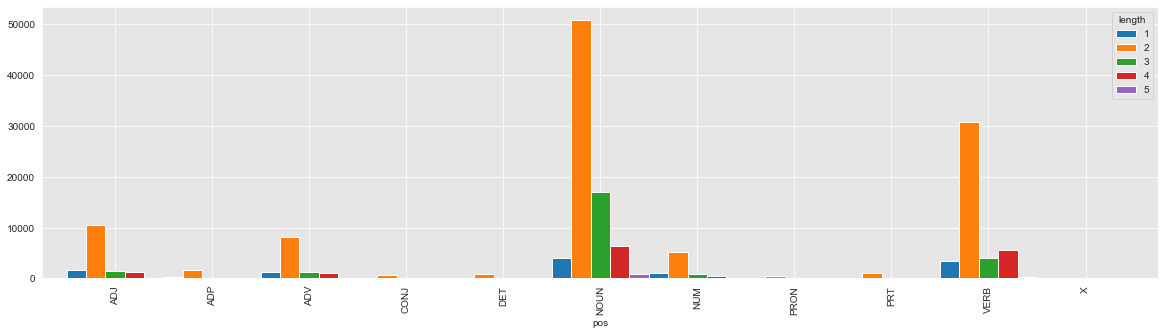

In [68]:
# by word length
max_term_len = 5
count_df = []
for length in range(1, max_term_len + 1):
    for pos in POSs:
        df_pos = df[df.pos == pos]
        val = len({t for t in df_pos.term if len(t) == length})
        count_df.append([length, pos, val])
count_df = pd.DataFrame(count_df, columns=('length', 'pos', 'val'))
count_df.pivot('pos', 'length', 'val').plot(kind='bar', figsize=(20,5), width=1)

## Same graph but normalized

<AxesSubplot:xlabel='pos'>

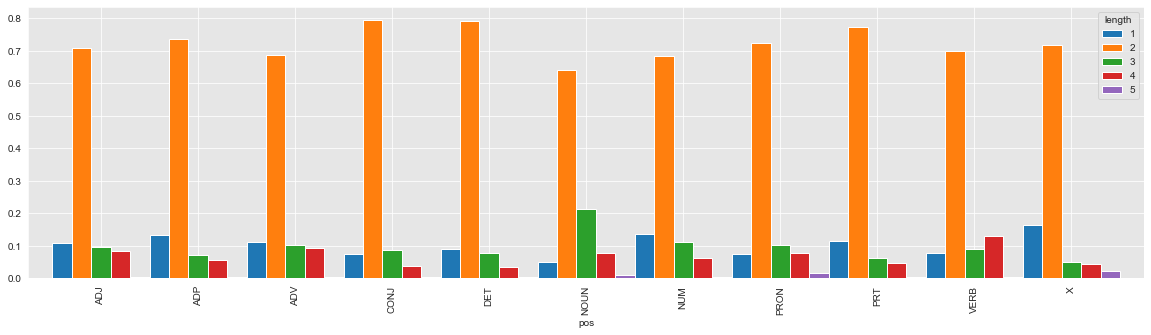

In [69]:
# by word length
count_df = []
for length in range(1, max_term_len + 1):
    for pos in POSs:
        df_pos = df[df.pos == pos]
        val = len({t for t in df_pos.term if len(t) == length}) / len(df_pos.term)
        count_df.append([length, pos, val])
count_df = pd.DataFrame(count_df, columns=('length', 'pos', 'val'))
count_df.pivot('pos', 'length', 'val').plot(kind='bar', figsize=(20,5), width=1)

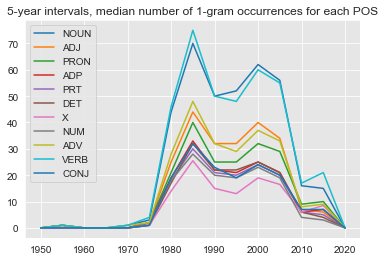

In [70]:
POSs = set(df.pos)
plt.title(f'{N_YEARS_PER_BLOCK}-year intervals, median number of 1-gram occurrences for each POS')
for pos in POSs:
    df_pos = df[df.pos == pos]
    y = [np.median(df_pos[f'{t}_n_occ']) for t in time_periods]
    plt.plot(time_periods, y, label=pos)

plt.legend()
plt.show()

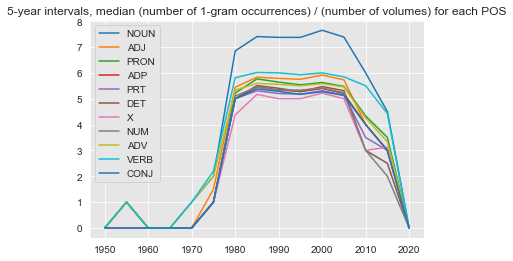

In [71]:
POSs = set(df.pos)
plt.title(f'{N_YEARS_PER_BLOCK}-year intervals, median (number of 1-gram occurrences) / (number of volumes) for each POS')
for pos in POSs:
    df_pos = df[df.pos == pos]
    y = [np.median(df_pos[f'{t}_n_occ_norm']) for t in time_periods]
    plt.plot(time_periods, y, label=pos)

plt.legend()
plt.show()

/tmp/ipykernel_202421/3427838389.py:5: RuntimeWarning: invalid value encountered in double_scalars
  y = [np.median(df_pos[f'{t}_n_occ']) / np.sum(df[f'{t}_n_occ']) for t in time_periods]


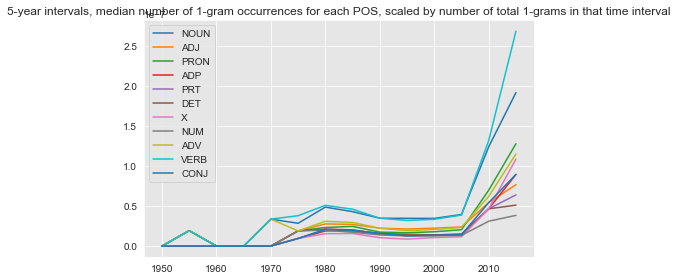

In [72]:
POSs = set(df.pos)
plt.title(f'{N_YEARS_PER_BLOCK}-year intervals, median number of 1-gram occurrences for each POS, scaled by number of total 1-grams in that time interval')
for pos in POSs:
    df_pos = df[df.pos == pos]
    y = [np.median(df_pos[f'{t}_n_occ']) / np.sum(df[f'{t}_n_occ']) for t in time_periods]
    plt.plot(time_periods, y, label=pos)

plt.legend()
plt.tight_layout()
plt.show()

## Frequency of top $k$ compositional first-children of length 1, 2, and 3 of given POS through time

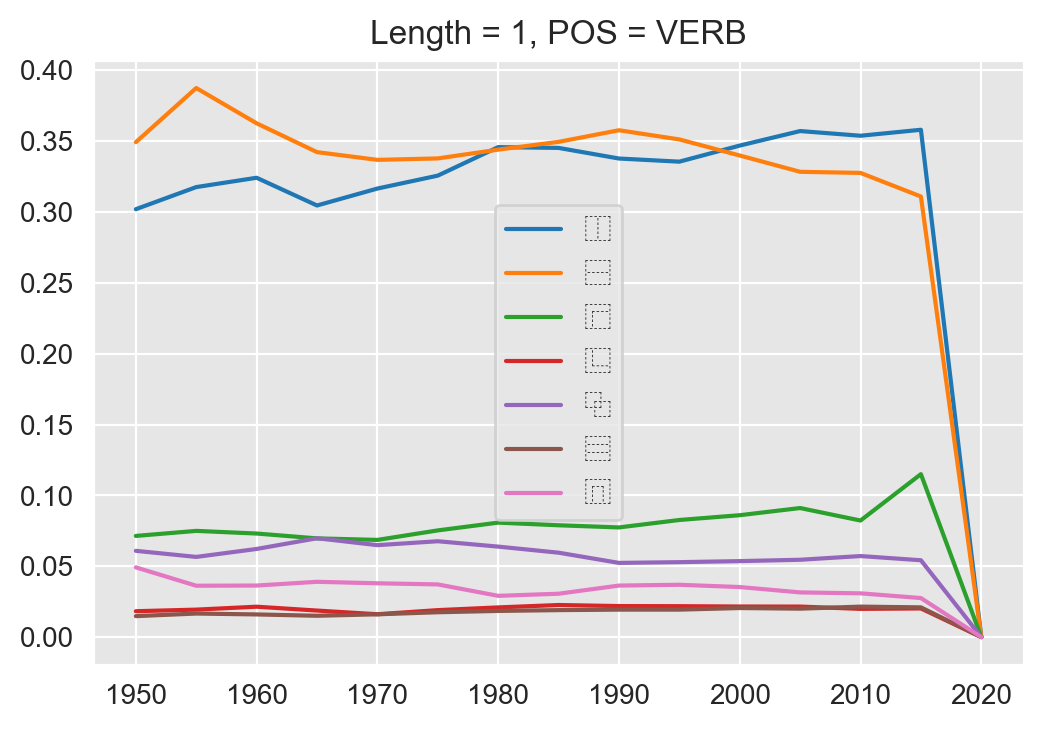

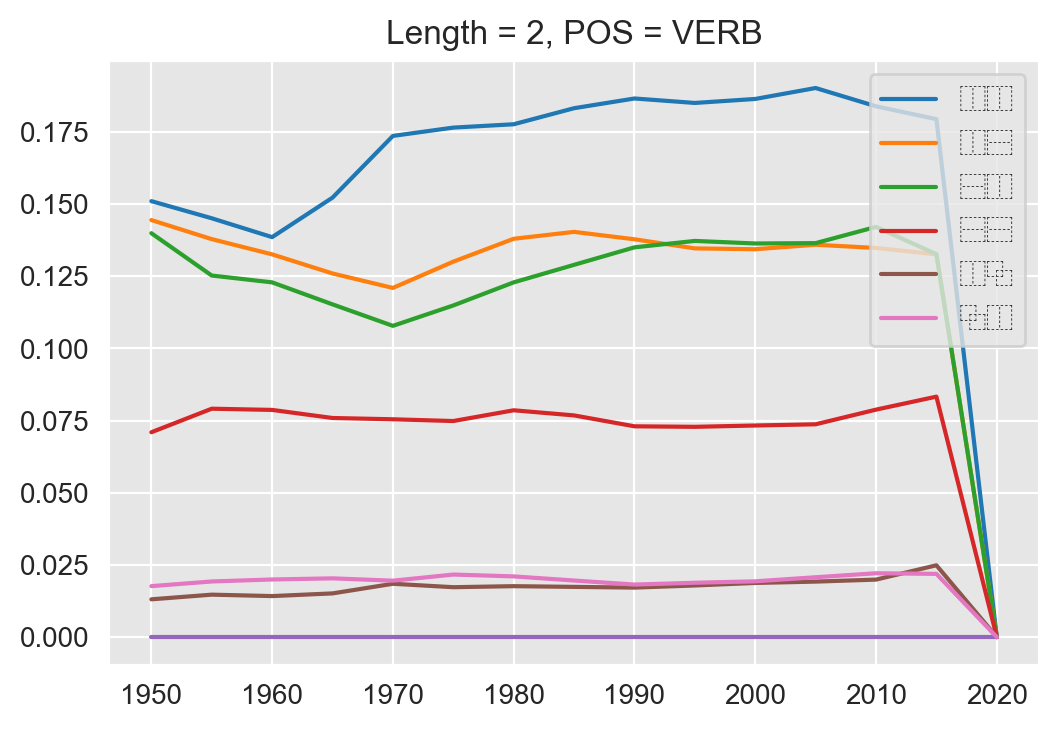

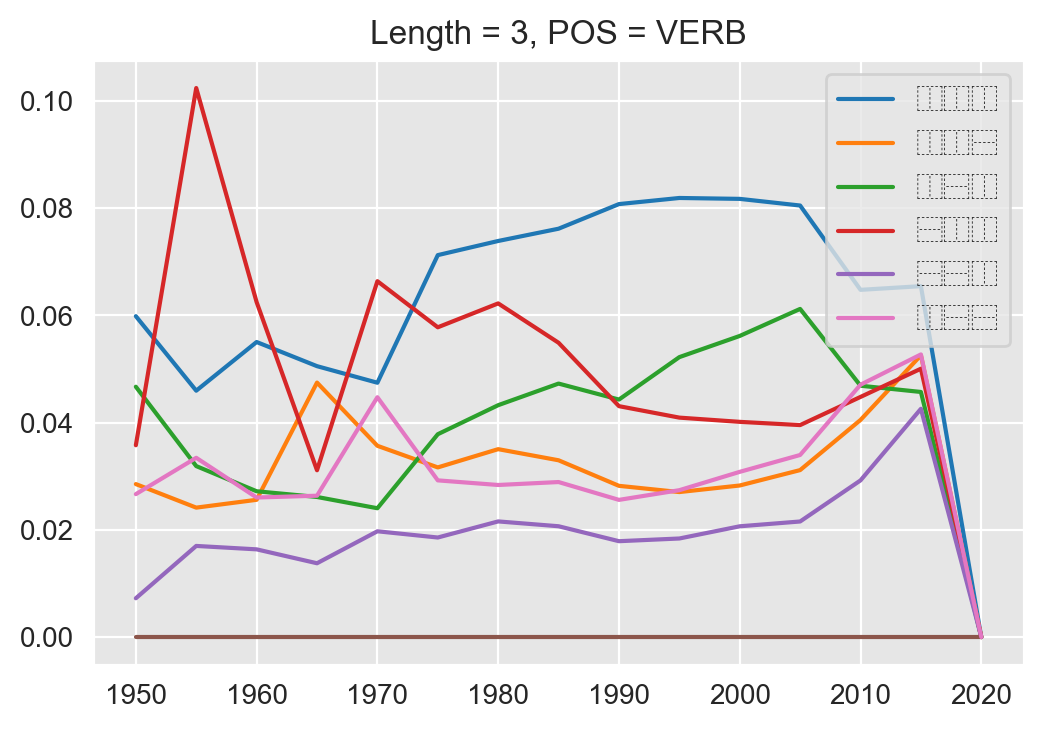

In [184]:
k = 7
POS = 'VERB'

for length in (1, 2, 3):
    plt.figure(dpi=200)
    plt.title(f'Length = {length}, POS = {POS}')
    df_noun = df[df.pos == 'NOUN']
    df_noun_with_length = df_noun[df_noun.term.apply(lambda term: len(term) == length)]
    most_common_compositions = Counter(df_noun_with_length.first_children).most_common(k)
    
    for comp, _ in most_common_compositions:
        df_noun_with_length_and_comp = df_noun_with_length[df_noun_with_length.first_children == comp]
        y = []
        for time_period in time_periods:
            denom = sum(df_noun_with_length[f'{time_period}_n_occ'])
            if not denom:
                y.append(0)
            else:
                y.append(sum(df_noun_with_length_and_comp[f'{time_period}_n_occ']) / denom)
        plt.plot(time_periods, y, label=comp)
    plt.legend(prop=prop)
    
    plt.show()

In [186]:
char_to_ids['王'].child.symbol

'⿱'

In [190]:
df[df.pos == 'VERB'].head(20)

,term,pos,1950_n_occ,1950_n_occ_norm,1955_n_occ,1955_n_occ_norm,1960_n_occ,1960_n_occ_norm,1965_n_occ,1965_n_occ_norm,...,2000_n_occ_norm,2005_n_occ,2005_n_occ_norm,2010_n_occ,2010_n_occ_norm,2015_n_occ,2015_n_occ_norm,2020_n_occ,2020_n_occ_norm,first_children
2,窝里斗,VERB,0,0.000000,0,0.000000,0,0.000000,0,0.000000,...,5.890909,46,6.575000,2,2.000000,21,5.821429,0,0,⿱⿱⿻
5,围捕,VERB,0,0.000000,0,0.000000,0,0.000000,0,0.000000,...,5.666667,32,5.166667,12,5.700000,13,4.500000,0,0,⿴⿰
11,可不是,VERB,0,0.000000,1,1.000000,0,0.000000,0,0.000000,...,5.808766,41,5.142857,23,7.750000,53,4.369048,0,0,⿹⿸⿱
14,立起,VERB,0,0.000000,26,6.100000,7,5.000000,0,0.000000,...,7.539122,333,7.398795,133,6.707677,135,4.572745,0,0,⿱⿺
24,珍重,VERB,0,0.000000,21,5.309524,6,3.000000,5,3.000000,...,5.785339,193,5.560864,31,5.666667,44,4.575000,0,0,⿰⿱
28,势,VERB,1,1.000000,546,8.968942,258,9.010827,131,8.903736,...,17.250151,26036,17.182941,2452,18.734612,1387,9.932074,0,0,⿱
29,就职,VERB,18,9.000000,110,10.166783,25,5.200000,11,6.500000,...,11.348731,4670,11.137557,672,13.910422,488,8.592381,0,0,⿰⿰
31,着落,VERB,0,0.000000,1,1.000000,1,1.000000,0,0.000000,...,5.208556,56,5.462637,6,3.000000,8,3.000000,0,0,⿸⿱
47,电动,VERB,0,0.000000,0,0.000000,3,2.000000,0,0.000000,...,2.000000,3,3.000000,1,1.000000,2,2.000000,0,0,⿻⿰
52,钱买,VERB,0,0.000000,0,0.000000,0,0.000000,0,0.000000,...,5.100000,31,5.166667,21,5.250000,29,4.250000,0,0,⿰⿱
